In [2]:
from imports import *

### Best despues de haber hecho gridsearch con toda la data
hps = {'batch_size': 14,
 'hidden_size': 25,
 'lookback': 28,
 'lr': 0.0003,
 'n_epochs': 300,
 'num_layers': 1,
 'output_size': 1,
 'final_train_loss': 0.013162605464458466,
 'final_test_loss': 0.024842604994773865,
 'train_time': 15.378505945205688}}



### Best config Vieja
hps = {'batch_size': 14,
 'hidden_size': 30,
 'lookback': 14,
 'lr': 0.0003,
 'n_epochs': 500,
 'num_layers': 1,
 'output_size': 1,
 'final_train_loss': 0.0298684760928154,
 'final_test_loss': 0.027125000953674316
}

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
warnings.filterwarnings("ignore")

#### Load data, split and create dataset

In [35]:
from utils import series_to_array
data = process_file()
timeseries = series_to_array(data)

In [36]:
len(timeseries)

488

In [6]:
train_size = int(len(timeseries) * 0.85)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [7]:
lookback=28

X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

from utils import scale_data

X_train, X_test, y_train, y_test, scaler_x, scaler_y = scale_data(X_train, X_test, y_train, y_test)

print("X_train", X_train.shape, "y_train", y_train.shape)
print("X_test",X_test.shape, "y_test",y_test.shape)

X_train torch.Size([386, 28, 1]) y_train torch.Size([386, 28, 1])
X_test torch.Size([46, 28, 1]) y_test torch.Size([46, 28, 1])


#### Defining LSTM Model and hyperparameters

In [18]:
from model import LSTMModel

model = LSTMModel(input_size=lookback, num_layers=1, hidden_size=25)
optimizer = optim.Adam(model.parameters(), lr=0.0003)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=14, drop_last=True)

In [19]:
model

LSTMModel(
  (lstm): LSTM(28, 25, batch_first=True)
  (linear): Linear(in_features=25, out_features=1, bias=True)
)

#### Training

In [27]:
from model import train_model
train_loss, train_rmse = train_model(model, loader, optimizer, loss_fn, 
                                     n_epochs=300, print_interval=50, seed=42)

In [28]:
X_train.shape

torch.Size([386, 28, 1])

#### Evaluating on train and test

In [29]:
from model import evaluate_model_last_prediction
train_preds, train_loss, test_loss, train_rmse, test_rmse, test_preds = evaluate_model_last_prediction(model, X_train, 
                                                                                                       y_train, X_test, y_test, scaler_y, loss_fn)

In [30]:
# creo un array concatenando las predicciones
train_preds = np.concatenate([tensor.flatten() for tensor in train_preds])
test_preds = np.concatenate([tensor.flatten() for tensor in test_preds])
len(train_preds), len(test_preds)

(386, 46)

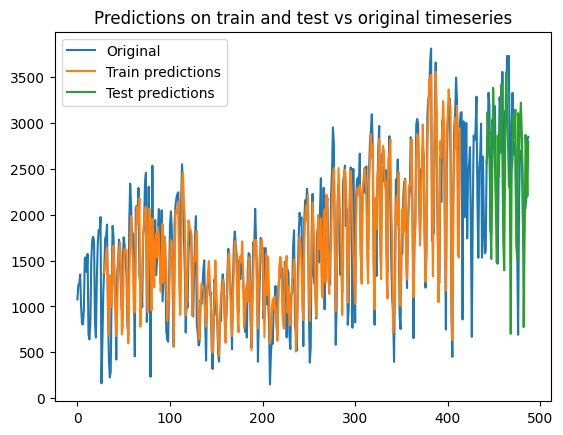

In [31]:
plt.plot(timeseries, label="Original")
plt.plot(range(lookback, lookback + len(train_preds)), train_preds, label="Train predictions")
plt.plot(range(2*lookback + len(train_preds), 2*lookback + len(train_preds) + len(test_preds)), test_preds, label="Test predictions")
plt.title("Predictions on train and test vs original timeseries")
plt.legend()

In [32]:
print("test:", test_loss, "train:",
      train_loss)

test: [0.03327596187591553] train: [0.010577856563031673]


#### Plotting correlation results

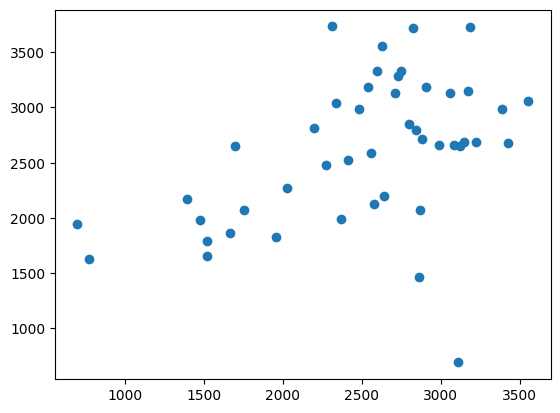

In [33]:
plt.scatter(test_preds, test[lookback:])

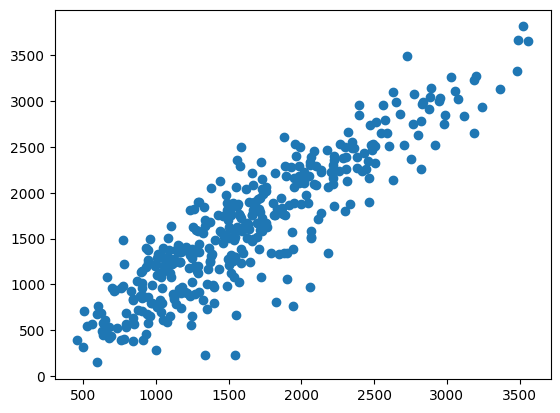

In [34]:

plt.scatter(train_preds, train[lookback:])